In [98]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

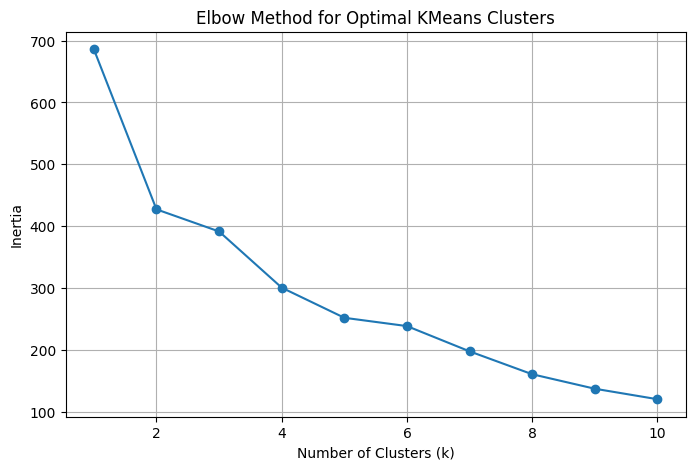

In [99]:
df = pd.read_csv('electricvehicles.csv')

# Convert FastCharge_KmH to numeric (some values may need cleaning)
df['FastCharge_KmH'] = pd.to_numeric(df['FastCharge_KmH'], errors='coerce')

# Select numerical columns
numerical_cols = ['AccelSec', 'TopSpeed_KmH', 'Range_Km', 'Efficiency_WhKm', 
                  'FastCharge_KmH', 'Seats', 'PriceEuro']

# Drop rows with missing values in numerical columns
df_numeric = df[numerical_cols].dropna()

# Preserve Brand and Model columns for reference
identifiers = df.loc[df_numeric.index, ['Brand', 'Model']].reset_index(drop=True)

# Normalize using StandardScaler
scaler = StandardScaler()
normalized_data = scaler.fit_transform(df_numeric)

# Convert back to DataFrame for clarity
normalized_df = pd.DataFrame(normalized_data, columns=numerical_cols)

# Add Brand and Model columns to the normalized DataFrame
normalized_df = pd.concat([identifiers, normalized_df], axis=1)

# Simulate a variety of KMeans values to determine optimal number of clusters
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_data)
    inertia.append(kmeans.inertia_)

# Plot the elbow chart
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal KMeans Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


In [100]:
# Apply KMeans with the chosen number of clusters (k=6)
kmeans_final = KMeans(n_clusters=6)#, random_state=42)
clusters = kmeans_final.fit_predict(normalized_data)

# Add cluster labels to the DataFrame
normalized_df['Cluster'] = clusters

# View the updated DataFrame
normalized_df.head()

,Brand,Model,AccelSec,TopSpeed_KmH,Range_Km,Efficiency_WhKm,FastCharge_KmH,Seats,PriceEuro,Cluster
0,Tesla,Model 3 Long Range Dual Motor,-0.990187,1.193357,0.848943,-0.965395,2.413510,0.059682,-0.054076,1
1,Volkswagen,ID.3 Pure,1.194996,-0.503240,-0.681497,-0.764741,-1.032469,0.059682,-0.801008,4
2,Polestar,2,-0.949720,0.658813,0.423821,-0.296546,0.815375,0.059682,-0.025934,1
3,BMW,iX3,-0.099927,-0.038419,0.083723,0.539516,0.515725,0.059682,0.314114,1
4,Honda,e,0.992664,-0.851856,-1.531741,-0.731298,-1.332119,-1.402517,-0.713153,0


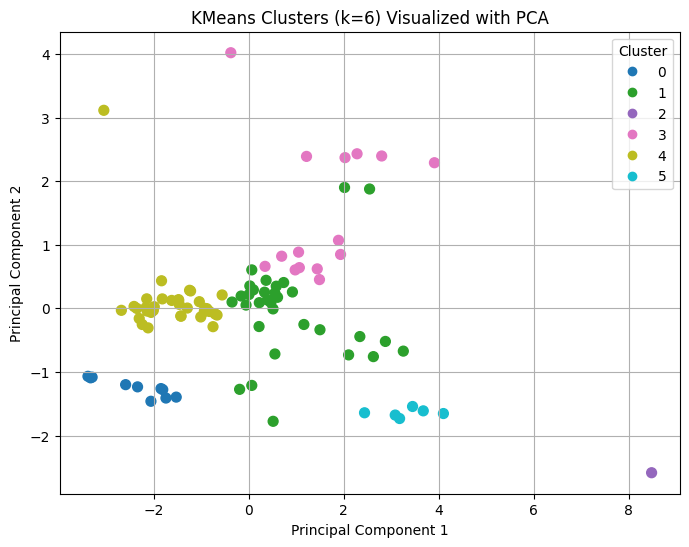

In [101]:
# Reduce dimensionality to 2D for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(normalized_data)

# Plot clusters in 2D
plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='tab10', s=50)
plt.title('KMeans Clusters (k=6) Visualized with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()


In [102]:
# Show PCA component weights (loadings)
pca_components = pd.DataFrame(pca.components_, columns=numerical_cols, index=['PC1', 'PC2'])
print("\nPCA Component Loadings:")
print(pca_components.T.sort_values(by='PC1', ascending=False))


PCA Component Loadings:
                      PC1       PC2
TopSpeed_KmH     0.458489 -0.128462
FastCharge_KmH   0.426814 -0.048324
PriceEuro        0.421822 -0.187206
Range_Km         0.410426  0.007523
Efficiency_WhKm  0.249939  0.507461
Seats            0.054957  0.828896
AccelSec        -0.442431  0.038387
